# Step 0: download PWS data from Internet repository & save in correct format

The PWSQC method has been developed to filter correct observations from PWS rainfall measurements. In the publication https://doi.org/10.1029/2019GL083731 by De Vos et al. (2019), this method is described and applied on a PWS dataset in the Amsterdam metropolitan area and the Netherlands. Both the code (https://github.com/LottedeVos/PWSQC) and the datasets (doi.org/10.4121/uuid:6e6a9788-49fc-4635-a43d-a2fa164d37ec) have been made freely available (cc-by-sa 4.0).

The PWS dataset is a collection of rainfall observations from Netatmo weather stations with tipping bucket modules. The raw observations, of rainfall amount in mm at variable time steps, have been adjusted to a data.frame, where each column represents a 5-min timeseries of a particular PWS. The original measurements are attributed to the first following fixed 5-min timestamp. If a 5-min window includes multiple observations, they are aggregated. If no observations are recorded within a 5-min window, the data.frame includes a NA-value. 

Note that the format of the input data used here is neither the most raw manner in which this type of data is stored, or a standardized format.

In order to get started, first read in the PWS dataset of 25 months in the Amsterdam metropolitan area. Make sure to set the working directory to the source file location (".../OPENSENSE_sandbox/PWSQC Rnotebook")


In [1]:
rm(list=(ls()))
url <- "https://data.4tu.nl/file/fa404032-4fb2-483d-bb9c-af043a25990c/da8b1115-88fa-45ec-97df-3d3d43e4ffaa"
temp <- tempfile()  # make temporary folder to download zip-file
download.file(url, temp, mode="wb")
AMS_dataset <- read.csv(unz(temp, "AMS_dataset.csv"))   # read AMS_dataset from downloaded zip-file
AMS_metadata <- read.csv(unz(temp, "AMS_metadata.csv"))   # read AMS_metadata from downloaded zip-file
unlink(temp)
rm(url, temp)


Note that with small adjustments in the file names in the code, you can also read the csv files with 1 month of PWS data and metadata in the whole Netherlands ("NL_dataset.csv" and "NL_metadata.csv") that are also part of the downloaded zip-file. For more information on the files in this repository, read the readme.txt file on https://data.4tu.nl/articles/dataset/Rainfall_observations_datasets_from_Personal_Weather_Stations/12703250/1?file=24056603. 

Some adjustments are needed to AMS_dataset before this input data fits what is generated in PWSQC_0 (which is the expected format later in the code). 


In [2]:
starttime <- strptime(AMS_dataset$Time[1], format="%Y-%m-%d %H:%M:%S", tz="GMT")
endtime <- strptime(AMS_dataset$Time[nrow(AMS_dataset)], format="%Y-%m-%d %H:%M:%S", tz="GMT")
save(starttime, endtime, file="OutputFolder/timerange_AMSdata.RData")	# save starttime and endtime of dataset in an R Object 
Ndataset <- as.matrix(AMS_dataset[,-1])
save(Ndataset, file="OutputFolder/Ndataset.RData") # save 'Ndataset' as matrix in an R Object in the folder "OutputFolder"
names(AMS_metadata)[1] <- "id" # first column should be named "id" instead of "ID"
AMS_metadata[,1] <- substr(AMS_metadata[,1], 4, nchar(AMS_metadata[,1]))  # get rid of prefix "ams" in the station id's. 
write.table(AMS_metadata, "InputFiles/metatableAms.txt", quote=F, row.names = F, sep=",") # save 'metadatatableAms' as txt-file in the folder "InputFiles".
rm(list=(ls()))


Now the Ndataset containing all PWS data is stored as a matrix in an RObject in "./OutputFolder", and the metadata is provided as a txt-file in the "./InputFiles" folder, which also includes the file "Filtersettings.txt". Manually adjust the settings in the filtersettings file if needed. The file currently includes the parameter values chosen for published results that were produced on the AMS dataset. From this, the PWSQC scripts as of PWSQC_1.R can be run. 

The starttime and endtime of the PWSdataset are stored for later in the visualisation. 


# Step 1: the construction of the neighbour list of all stations in the PWS dataset 

## Input: 
-Text file 'Meta' (located in Folder 'InputFiles') containing the locations in Lon and Lat and unique ID, corresponding to those in the names of the raw PWS observation text files. \
-Filtersettings as provided in Inputfiles/FilterSettings.txt. \

## Output: 
-A list of length equal to the number of stations in Meta data, of vectors providing the ID's of neighbour stations in the order of ID's in Meta. \

## Notes: 
-The output is written in Folder 'OutputFolder', with the label of that combination of Filtersettings. \
-The following code includes some changed suggested by end-users after the initial publication of the code. Note that these changes may lead to very slight differences from the results published in the paper by De Vos et al. (2019). \
-Initially the code made a projection of the lon and lat locations (in rijksdriehoekscoordinaten) in order to calculate distances between stations in meter. \
The projection that was used is appropriate for the Netherlands, but not for other areas in the world. \
These lines in the code had been replaced with a function from the geosphere package, which calculates distance between stations directly from their lon and lat locations. \
The function (distHaversine) assumes a spherical earth, ignoring ellipsoidal effects. The new code is applicable on PWS networks anywhere in the world.\
Courtesy of Dr. Maarten Reyniers and Eva Beele.\
-It is possible to run the code faster using the sf package and a maximum limit for the number of neighbour PWSs (if more nearby stations are available only the closest neighbours are considered). See PWSQC_1_alternativeversion.R for that approach. This seems always to give -0.1117411% shorter distances, but seems 15 times faster.\
Courtesy of Dr. Aart Overeem and Niek van Andel.\


In [3]:
library(geosphere) # to calculate distance bewteen lat/lon coordinates
source("InputFiles/Filtersettings.txt")	# obtain 'range', 'nstat', 'nint', 'HIthresA', 'HIthresB', 'compareint', 'rainyint', 'matchint', 'corthres' and 'Filtersettings'
Meta <- read.table("InputFiles/metatableAms.txt", header=T, sep=",")
 # # Construction of neigbourlist for each station # #
neighbourlist <- vector("list", nrow(Meta)) 
for(i in 1:nrow(Meta)){
    dist <- distm(cbind(Meta$lon, Meta$lat), c(Meta$lon[i], Meta$lat[i]), fun = distHaversine)	# make a list of distances to all stations including itself
	neighbourlist[[i]] <- Meta$id[which(dist > 0 & dist <= range)] }	# select the ID's of stations where the distance is smaller than 'range' but larger than zero to avoid being matched with itself
save(neighbourlist, file=paste0("OutputFolder/neighbourlist_Filtersettings",Filtersettings,".RData"))	# save 'neighbourlist' as list in an R Object 
rm(list=(ls()))


Now the neigbourlist indicating which stations are considered neighbours for each PWS as a list in an RData object in folder "./Outputfolder". As this relates to the filtersettings (in particular the range), the Filtersetting label is attached to the filename. 

# Step 2: the attribution of FZ and HI flags to the Ndataset

## Input: 
-'Ndataset' as constructed in PWSQC_0.R. \
-'neighbourlist' as constructed in PWSQC_1.R. \
-Text file 'Meta' (located in Folder 'InputFiles') containing the locations in Lon and Lat and unique ID, corresponding to those in the names of the raw PWS observation text files. \
 -Text file 'Filtersettings' (located in Folder 'InputFiles') \

## Output:
-A matrix 'FZ_flags' with equal size as 'Ndataset' that consists of '0', '1' or '-1' to indicate the attribution of Faulty Zero flags. The order of the columns corresponds with the order of the IDs in the Meta table. This is saved as R Object. \
-A matrix 'HI_flags' with equal size as 'Ndataset' that consists of '0', '1' or '-1' to indicate the attribution of High Influx flags. The order of the columns corresponds with the order of the IDs in the Meta table. This is saved as R Object. \

## Notes:
-The construction of 'Ndataset' and 'Rdataset' does not rely on any of the filter settings. They do depend on the period. Make sure the chosen 'starttime' and 'endtime' correspond with those in PWSQC_0.R. \
-Allthough the HI-filter and FZ-filter are seperate modules, these flags are attributed at the same time for time efficiency. \
  0 = No flag \
  1 = A flag is attributed \
 -1 = Not enough information to determine flag \


In [4]:
source("InputFiles/Filtersettings.txt")	# obtain 'range', 'nstat', 'nint', 'HIthresA', 'HIthresB', 'compareint', 'rainyint', 'matchint', 'corthres' and 'Filtersettings'
load("OutputFolder/Ndataset.RData")
load(paste0("OutputFolder/neighbourlist_Filtersettings",Filtersettings,".RData"))
Meta <- read.table("InputFiles/metatableAms.txt", header=T, sep=",")

In [5]:
# # Construct HI and FZ flags # #
for(i in 1:10){
   print(paste("FZ_flags and HI_flags construction progress:", i, "out of", nrow(Meta)))
	Nint <- Ndataset[,i]
	if((length(which(is.na(Nint)==F)) < 1) | (length(neighbourlist[[i]]) < nstat)){	# if the 'Nint' column consist of no observations or there are too few neighbours, make a sequence of -1 values
		  HIflag <- FZflag <- rep(-1, times=length(Nint))
   		  if(exists("HI_flags")==F){ HI_flags <- HIflag
			}else{ HI_flags <- cbind(HI_flags, HIflag) }
 		  if(exists("FZ_flags")==F){ FZ_flags <- FZflag
			}else{ FZ_flags <- cbind(FZ_flags, FZflag) }
	}else{
   NeighbourVal <- Ndataset[,which(Meta$id %in% neighbourlist[[i]])]	# take a subset of 'Ndatasset' with only the columns corresponding with the ID's of the neighbouring stations
   Ref <- rep(NA, times=length(Nint))
   Number_of_measurements <- apply(NeighbourVal, 1, function(x) length(which(is.na(x)==F)))	# count the number of neighbours with measurements at each interval
   Med <- apply(NeighbourVal, 1, median, na.rm=T)	# take the median of all neighbour values
   # # # HI-filter:
   HIflag <- rep(0, times=length(Nint))
   HIflag[which(((Nint > HIthresB) & (Med < HIthresA)) | ((Med >= HIthresA) & (Nint > (HIthresB*Med/HIthresA))))] <- 1  # if thresholds are exceeded, the HI flag becomes 1
   HIflag[which(Number_of_measurements < nstat)] <- -1	# if less than 'nstat' neighbours supply observations, the HI flag becomes equal to -1
   if(exists("HI_flags")==F){ HI_flags <- HIflag
	}else{ HI_flags <- cbind(HI_flags, HIflag) }
   # # # FZ-filter:
   Ref[which(Med == 0)] <- 0
   Ref[which(Med >  0)] <- 1
   Ref[which(Number_of_measurements < nstat)] <- NA	# make binary reference with 1 for rainy periods and 0 for dry periods (based on median of neighbour observations and NA when not enough info is available
   Nwd <- Nint
   Nwd[which(Nint > 0)] <- 1		# make binary timeseries of station observations where 1 stands for wet and 0 for dry observations
   runs <- rle(Nwd)
   rownr <- cumsum(runs$lengths)	
   endrow <- rownr[ which(runs$lengths > nint & runs$values==0) ]
   startrow <- endrow - runs$lengths[ which(runs$lengths > nint  & runs$values==0) ] + 1	# 'endrow' and 'startrow' indicate the boundaries of dry periods as measured by the station
   FZflag <- rep(0, times=length(Nint))	
   if(length(endrow) > 0){
   for(r in 1:length(endrow)){
   	if(length( which( (Ref[startrow[r] : endrow[r]]) == 1) ) > nint ){	# in case at least 'nint' intervals in 'Ref' are wet where 'Nint' is dry
	runs2 <- rle(Ref[startrow[r] : endrow[r]])	# check if the 'nint' wet intervals in 'Ref' are consecutive. 
   	rownr2 <- cumsum(runs2$lengths)	
   	endrow2 <- rownr2[ which(runs2$lengths > nint & runs2$values==1) ]
   	startrow2 <- endrow2 - runs2$lengths[ which(runs2$lengths > nint  & runs2$values==1) ] + 1	
	if(length(startrow2) > 0){
	FZstartrow <- startrow[r] + startrow2[1] - 1 + nint	# the interval in 'Nint' where the previous 'nint' intervals were dry in 'Nint' and wet in the median
   	FZflag[FZstartrow : endrow[r]] <- 1	# from this interval up to the end of the dry period is flagged as Faulty Zero
	
	m <- 1
	while((is.na(Nwd[endrow[r] + m])|(Nwd[endrow[r] + m] == 0)) & ((endrow[r]+m) <= length(Nwd)) ){ # if subsequent values in 'Nwd' are NA or 0, continue flagging until 'Nwd' becomes 1 or the end of 'Nwd' is reached
	 FZflag[endrow[r]+m] <- 1	# once a period is labeled as Faulty Zero, flagging continues until there is a rain measurement (NA values are ignored)
	 m <- m+1
	} # end while-loop
	}} # end if loops
   } # end r-loop
   } # end if loop (endrow)
   FZflag[which(Number_of_measurements < nstat)] <- -1	# if too few neighbours have observations the FZ can not be attributed
   if(exists("FZ_flags")==F){ FZ_flags <- FZflag
	}else{ FZ_flags <- cbind(FZ_flags, FZflag) }
	} #end of ifelse loop
} # end of i-loop
save(FZ_flags, file=paste0("OutputFolder/FZ_flags_Filtersettings",Filtersettings,".RData"))	# save 'FZ_flags' as matrix in an R Object 
save(HI_flags, file=paste0("OutputFolder/HI_flags_Filtersettings",Filtersettings,".RData"))	# save 'HI_flags' as matrix in an R Object 
rm(list=(ls()))

[1] "FZ_flags and HI_flags construction progress: 1 out of 134"
[1] "FZ_flags and HI_flags construction progress: 2 out of 134"
[1] "FZ_flags and HI_flags construction progress: 3 out of 134"
[1] "FZ_flags and HI_flags construction progress: 4 out of 134"
[1] "FZ_flags and HI_flags construction progress: 5 out of 134"
[1] "FZ_flags and HI_flags construction progress: 6 out of 134"
[1] "FZ_flags and HI_flags construction progress: 7 out of 134"
[1] "FZ_flags and HI_flags construction progress: 8 out of 134"
[1] "FZ_flags and HI_flags construction progress: 9 out of 134"
[1] "FZ_flags and HI_flags construction progress: 10 out of 134"


The results are saved as matrices named FZ_flags and HI_flags in RObjects. The values 0, 1 and -1 in these matrices convey whether the Ndataset observation at the corresponding location in Ndataset has been attributed respectively 'no flag', 'error flag' or 'not enough information to attribute flag'. 


# Step 3: the attribution of SO flags and bias correction factors to the Ndataset is excluded in this minimal example..

# Step 4: visualisation 

Use the script below to visualize aggregated rainfall over a period of time. First load all data and filter outputs. 


In [6]:
source("InputFiles/Filtersettings.txt")	# obtain 'range', 'nstat', 'nint', 'HIthresA', 'HIthresB', 'compareint', 'rainyint', 'matchint', 'corthres' and 'Filtersettings'
load("OutputFolder/timerange_AMSdata.RData")
Meta <- read.table("InputFiles/metatableAms.txt", header=T, sep=",")
load("OutputFolder/Ndataset.RData")
Ndataset <- Ndataset[,1:10]
load(paste0("OutputFolder/FZ_flags_Filtersettings",Filtersettings,".RData"))
load(paste0("OutputFolder/HI_flags_Filtersettings",Filtersettings,".RData"))
load(paste0("OutputFolder/neighbourlist_Filtersettings",Filtersettings,".RData"))
Time <- seq(starttime, endtime, by= "5 min")


## Plot cumulative time series of raw data



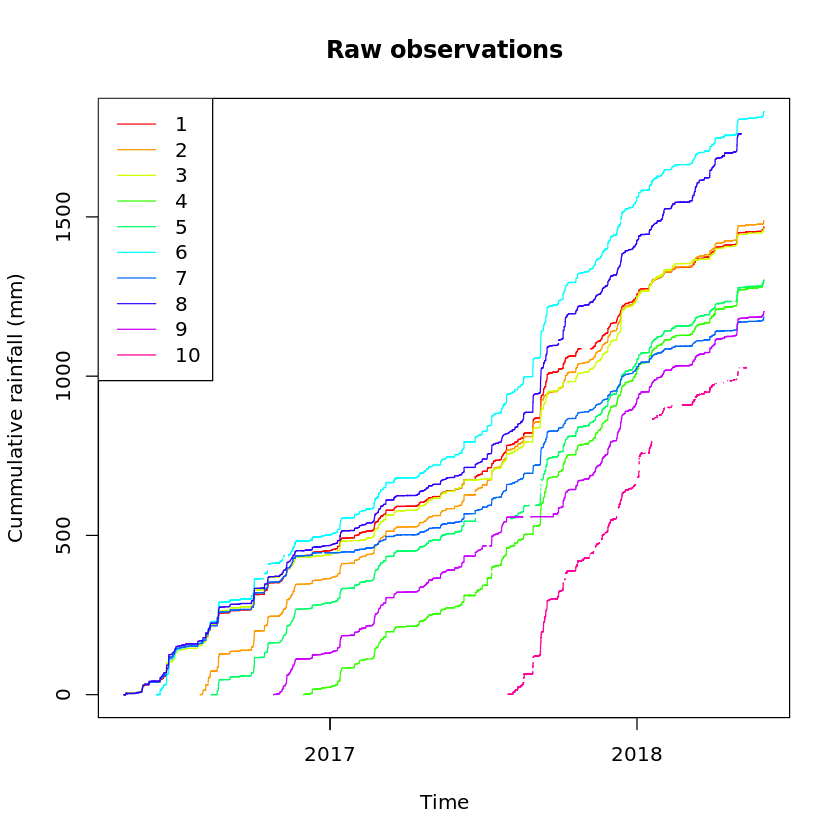

In [7]:
ymax <- 1800 # mm upper limit of the graph
#StationSelec <- c(1:10)  # fill in the id's in Meta that you want plotted. Must be at least one but can be several.
# example: #
StationSelec <- 1:10  
plot(Time, rep(NA, times=length(Time)), ylim=c(0,ymax), ylab="Cummulative rainfall (mm)", main="Raw observations")
for(s in 1:length(StationSelec)){
  N_ac <-  cumsum(ifelse(is.na(Ndataset[,StationSelec[s]]), 0, Ndataset[,StationSelec[s]])) + Ndataset[,StationSelec[s]]*0 
  lines(Time, N_ac, col=rainbow(length(StationSelec))[s]) # makes cumulative plots even if values are missing. 
}
legend("topleft", legend=StationSelec, lty=1, col=rainbow(length(StationSelec))[1:length(StationSelec)])


## Plot cumulative time series of raw data, indicating filtered intervals



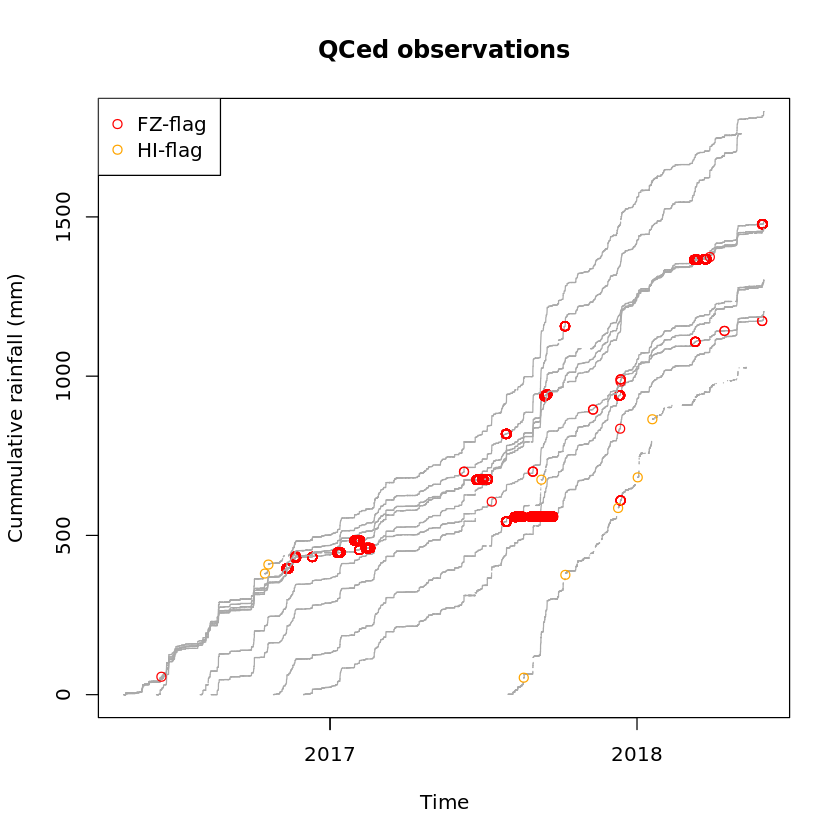

In [8]:
ymax <- 1800 # mm upper limit of the graph
#StationSelec '<- c("...")  # fill in the id's in Meta that you want plotted. Must be at least one but can be several.
# example: #
StationSelec <- 1:10  
Ndataset2 <- Ndataset
plot(Time, rep(NA, times=length(Time)), ylim=c(0,ymax), ylab="Cummulative rainfall (mm)", main="QCed observations")
for(s in 1:length(StationSelec)){
  N_ac <-  cumsum(ifelse(is.na(Ndataset2[,StationSelec[s]]), 0, Ndataset2[,StationSelec[s]])) + Ndataset2[,StationSelec[s]]*0 
  lines(Time, N_ac, col="darkgrey") # makes cumulative plots even if values are missing. 
  
  points(Time[which(FZ_flags[,StationSelec[s]]==1)], N_ac[which(FZ_flags[,StationSelec[s]]==1)], col="red") # plot intervals with FZ flag
  points(Time[which(HI_flags[,StationSelec[s]]==1)], N_ac[which(HI_flags[,StationSelec[s]]==1)], col="orange") # plot intervals with HI flag  
}
legend("topleft", legend=c("FZ-flag", "HI-flag"), pch=1, col=c("red", "orange"))


## Plot raw rainfall amounts over selected interval amounts geographically
 


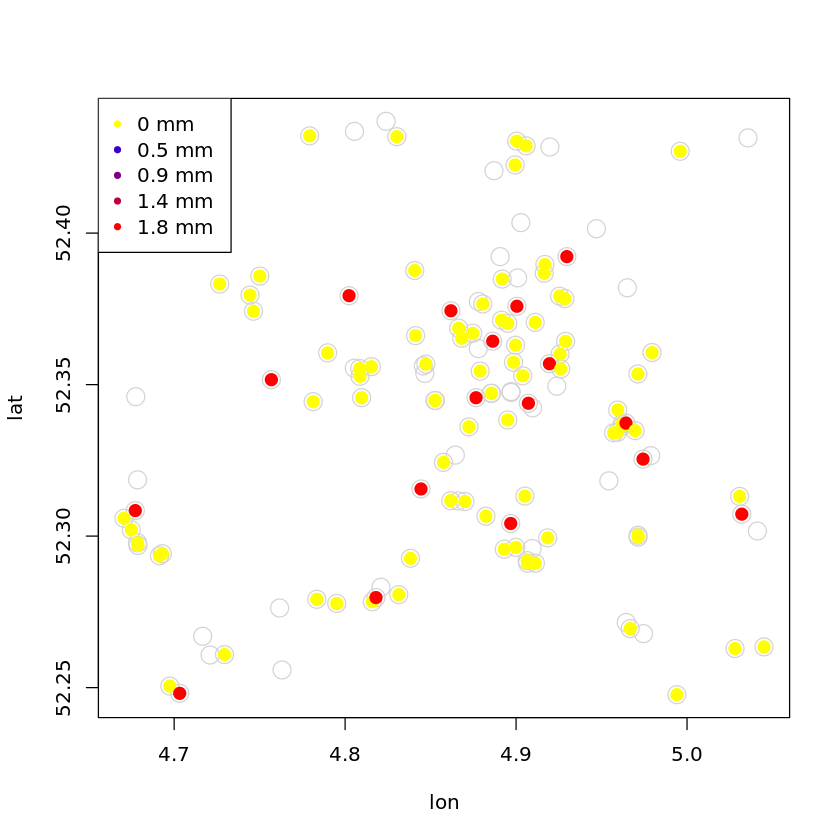

In [9]:
plotstart <- strptime("2016-08-20 00:00:00", format="%Y-%m-%d %H:%M:%S", tz="GMT")
plotend <- strptime("2016-08-21 00:00:00", format="%Y-%m-%d %H:%M:%S", tz="GMT")
if(plotstart < starttime | plotend > endtime){stop("The selected plot period is out of bounds.")}
Ndataset3 <- Ndataset
# if you want to plot filtered data, run the previous code for all
# the columns in Ndataset (all stations) by looping i through 1:nrow(Meta)
# in the FZ filter code and uncomment the following line
#Ndataset3[which(FZ_flags == 1 | HI_flags == 1)] <- NA # if a value is flagged, replace it for NA. 
Ntimeselec <- Ndataset3[which(Time >= plotstart & Time <= plotend),]
DataAvailabilityThreshold <- 0.8 # needs to have at least 80 % of data availability for a cumulative sum to be calculated. 
Raintimeselec <- colSums(Ntimeselec, na.rm=T)
fracdata <- apply(Ntimeselec, 2, function(x) length(which(is.na(x)==F))/length(x))	# counts fraction of time intervals with non-NA observations.  
Raintimeselec[which(fracdata < DataAvailabilityThreshold)] <- NA
if(all(is.na(Raintimeselec))){stop("No station with sufficient data in selected plot period.")}
# make a color indication based on the cumulative amounts
colfunc <- colorRampPalette(c("blue", "red"))
colval <- round(100 * (Raintimeselec/max(Raintimeselec, na.rm=T))) # rewrite each cumulative value to the shade closest to it's 1/100 value. 
colorlist <- colfunc(100)[colval]
colorlist[which(colval == 0)] <- "yellow"  # plot zero values as yellow circles. 
plot(Meta$lon, Meta$lat, pch=1, col="lightgrey", cex=2, xlab="lon", ylab="lat")
points(Meta$lon, Meta$lat, col=colorlist, pch=20, cex=2)
legend("topleft", legend=paste(round(seq(0, max(Raintimeselec, na.rm=T), length=5),digits=1), "mm"), col=c("yellow", colfunc(100)[c(25, 50, 75, 100)]), pch=20)
  
